<a href="https://colab.research.google.com/github/PhD-Gabriel-Caballero/ESA-summer-school-2023-Croatia/blob/main/Unsupervised_land_cover_classification_based_on_S1_time_series_using_machine_learning_algorithms_in_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Unsupervised land cover classification based on S1 time series using machine learning algorithms in GEE

---

This Jupyter notebook contains all the necessary information for land cover unsupervised classification based on Sentinel-1 time series in the Google Earth (GEE) cloud computing platform. This material has been created exclusively for the 2023 European Space Agency (ESA) summer school.

---

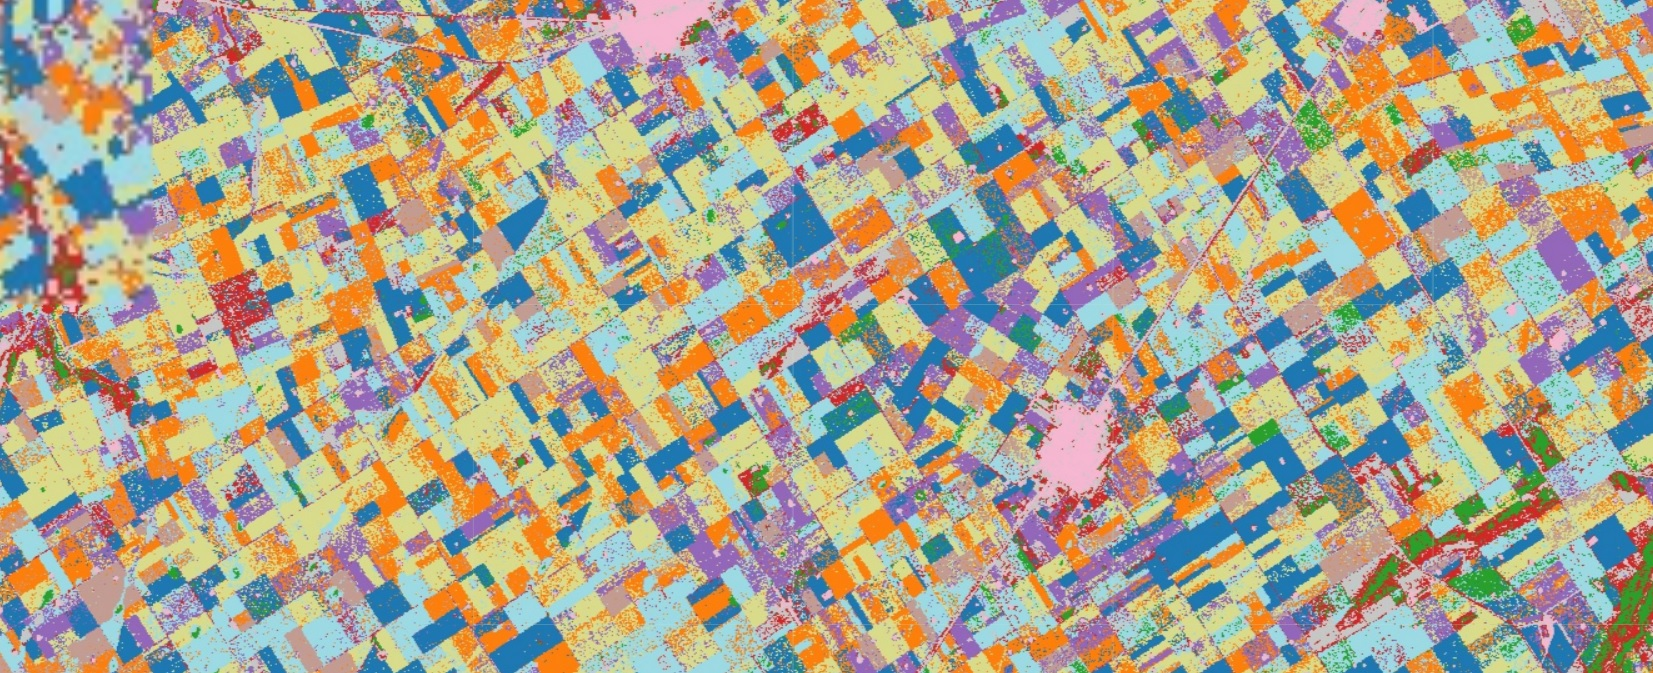

In this study, we investigate the use of the S1 time series for thematic crop mapping in an intensively cultivated Argentinian valley. SAR data, while not optimal for vegetation classification, is advantageous as it is not affected by cloud cover.

This area comprises vast agricultural fields with well-defined crops and flat terrain, which is a significant advantage for SAR measurement.

---

Credits and references


Original source code:
[Machine Learning with Earth Engine - Unsupervised Classification](https://geemap.org/notebooks/31_unsupervised_classification/)

[1] Caballero, G.R.; Platzeck, G.; Pezzola, A.; Casella, A.; Winschel, C.; Silva, S.S.; Ludueña, E.; Pasqualotto, N.; Delegido, J. Assessment of Multi-Date Sentinel-1 Polarizations and GLCM Texture Features Capacity for Onion and Sunflower Classification in an Irrigated Valley: An Object Level Approach. Agronomy 2020, 10, 845. https://doi.org/10.3390/agronomy10060845

## Theoretical background

---

**Unsupervised classification**

Unsupervised classification algorithms use statistical features to cluster pixels or objects into classes, without needing training data.

You can find additional information by clicking on the following link
[Unsupervised Classification - an overview](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/unsupervised-classification#:~:text=The%20goal%20of%20the%20unsupervised,technique%20for%20statistical%20data%20analysis.)

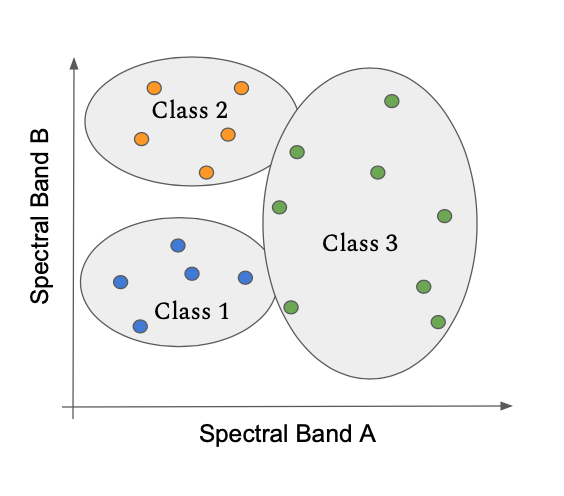

Image adapted from
[Land cover classification in GEE](https://openmrv.org/web/guest/w/modules/mrv/modules_1/land-cover-and-land-use-classification-in-google-earth-engine)

---

**Unsupervised Classification (clustering) in GEE**

The ee.Clusterer package handles unsupervised classification (or clustering) in Earth Engine. These algorithms are currently based on the algorithms with the same name in Weka. More details about each Clusterer are available in the reference docs in the Code Editor.

Clusterers are used in the same manner as classifiers in Earth Engine. The general workflow for clustering is:

1.   Assemble features with numeric properties in which to find clusters.
2.   Instantiate a clusterer. Set its parameters if necessary.
3.   Train the clusterer using the training data.
4.   Apply the clusterer to an image or feature collection.
5.   Label the clusters.

You can find additional information by clicking on the following link
[Unsupervised classification GEE](https://developers.google.com/earth-engine/guides/clustering)

**Install the required Python packages**

In [ ]:
!pip install -U geemap
!pip install PyCRS

**Import libraries**

In [2]:
from google.colab import output
output.enable_custom_widget_manager()
from datetime import datetime

import ee, geemap, sys, pycrs
import geemap.colormaps as cm

**Mount Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Clone the GitHub repository**

In [ ]:
!rm -r ESA-summer-school-2023-Croatia # delete the complete repository folder
!git clone https://github.com/PhD-Gabriel-Caballero/ESA-summer-school-2023-Croatia # clone repository folder
sys.path.insert(0,'/content/ESA-summer-school-2023-Croatia')

**To use the Earth Engine API on the GEE cloud platform, import ee and geemap, and then log in to authenticate**

In [5]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

**Define and visualize the study area**

In [6]:
# Set map center
map_center_lat = -33.512774
map_center_lon = -61.48914

# Set map display properties.
Map = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map.default_style = {'cursor': 'crosshair'}
Map.add_basemap('SATELLITE')

# Center the map in the desired point

Map= geemap.Map(center=(map_center_lat,map_center_lon), zoom=8)
Map.add_basemap('HYBRID')

Map

Map(center=[-33.512774, -61.48914], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

**Retrieve the ROI from the map for classifier training**

In [7]:
#Please draw a shape, such as a rectangle, on the map and then execute this code snippet
training_region = Map.user_roi

**Funtions definition**

In [8]:
#Function to convert from dB
def toNatural(img):
    return ee.Image(10.0).pow(img.select(0).divide(10.0))

#Function to convert to dB
def todB(img):
    return ee.Image(img).log10().multiply(10.0)

In [9]:
# Clipping image collection by geometry
def clipcol(image):
    clipimage = image.clip(training_region)
    return clipimage

In [29]:
def class2mask(image, land_cover_class):
  class_number = land_cover_class
  mask = image.eq(class_number)
  return image.updateMask(mask)

**Dates of interest and acquisitions configuration parameters**

In [10]:
# Configuration Parameters
start_date = '2020-02-01'
end_date = '2021-02-01'
RON = 141 # Relative Orbit Number
Platform_number = 'B'

# Select the current region of interest
roi_center_lat = -33.512774
roi_center_lon = -61.48914

roi_point = ee.Geometry.Point([roi_center_lon, roi_center_lat])

**Create the initial image collection with the polarimetric SAR bands**

In [ ]:
# Retrieving Sentinel 1 imagery
print('SENTINEL1 time series being retrieved')
S1collection = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')\
                     .filterBounds(roi_point)\
                     .filterDate(start_date, end_date)\
                     .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                     .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
                     .filter(ee.Filter.eq('instrumentMode', 'IW'))\
                     .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
                     .filter(ee.Filter.eq('resolution','H'))\
                     .select('VH','VV')\

# Sort the dataset S1
S1collection = S1collection.sort('GRD_Post_Processing_start');

**Filter the S1 SAR collection**

In [12]:
# Filter S1 collection by Relative Orbit Number or Path 141 and satellite S1-B
S1collection  =  S1collection.filter(ee.Filter.eq('relativeOrbitNumber_start',RON)).filter(ee.Filter.eq('platform_number',Platform_number))

# Polarization filtering
S1collection_VH  = ee.ImageCollection(S1collection.select(["VH"])).map(todB)
S1collection_VV  = ee.ImageCollection(S1collection.select(["VV"])).map(todB)

# From GEE image collection to one image containing multiple bands
image_S1_VH = S1collection_VH.toBands(); # S1 VH polarization
image_S1_VV = S1collection_VV.toBands(); # S1 VV polarization

image_S1 = S1collection.toBands(); # S1 VH&VV polarization

**Make training dataset**

In [13]:
# Make the training dataset.
S1_training_dataset = image_S1_VH.sample(
    **{
        #'region': training_region, #If you do not define a region, it will use the image footprint by default
        'scale': 10,
        'numPixels': 5000,
        'seed': 5,
        'geometries': True,  # Set this to False to ignore geometries
    }
)

**Create an interactive map for S1 VH and VV polarimetric bands visualization**

In [14]:
map_center_lat = -33.512774
map_center_lon = -61.48914

Map_S1 = geemap.Map()
Map_S1 = geemap.Map(center=(map_center_lat,map_center_lon), zoom=8)
Map_S1.set_plot_options(add_marker_cluster=True)

Map_S1.addLayer(S1_training_dataset, {}, 'training', True)
Map_S1

Map(center=[-33.512774, -61.48914], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

**Add data to the map**

In [19]:
vis_VH = cm.get_palette('gray', n_class=10)
vis_VH = {'min': -30, 'max': -15, 'palette': vis_VH}

vis_VV = cm.get_palette('gray', n_class=10)
vis_VV = {'min': -17, 'max': -8, 'palette': vis_VV}

# Image collection display (mean, max or min).

Map_S1.addLayer(S1collection_VH.mean(),vis_VH, 'S1 VH collection mean')
Map_S1.addLayer(S1collection_VV.mean(),vis_VV, 'S1 VV collection mean')

# On-screen display of color bars

Map_S1.add_colorbar(vis_VH, label="VH [dB]", orientation="horizontal", layer_name="VH color bar", position="topleft", location="bottom")
Map_S1.add_colorbar(vis_VV, label="VV [dB]", orientation="horizontal", layer_name="VV color bar", position="topleft", location="bottom")

**Train the clusterer**

In [20]:
# Instantiate the clusterer and train it.
n_clusters = 10
S1_clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(S1_training_dataset)

**Classify the image**

In [21]:
# Cluster the input using the trained clusterer.
S1_classification_result = image_S1_VH.cluster(S1_clusterer)

**Add data to the map**

In [ ]:
map_center_lat = -33.512774
map_center_lon = -61.48914

Map_S1_clusters = geemap.Map()
Map_S1_clusters = geemap.Map(center=(map_center_lat,map_center_lon), zoom=8)
Map_S1_clusters.set_plot_options(add_marker_cluster=True)

# Image collection display (mean, max or min).
Map_S1_clusters.addLayer(S1collection_VH.mean(),vis_VH, 'S1 VH collection mean')

# Define a legend dictionary

legend_dict = {

    '0 Barren Land (Rock/Sand/Clay)': '82ba9e',
    '1 Developed High Intensity': 'ab0000',
    '2 Crop class 1': 'dec5c5',
    '3 Roads and bare soil': 'd99282',
    '4 Crop class 2': 'b3ac9f',
    '5 Crop class 3': 'ccb879',
    '6 Water': '466b9f',
    '7 Wetland': '1c5f2c',
    '8 Crop class 4': 'ab6c28',
    '9 Crop class 5': 'dcd939',
}

# Define a colour palette for the clusters
legend_colors = ['82ba9e','ab0000','dec5c5','d99282','b3ac9f','ccb879','466b9f','1c5f2c','ab6c28','dcd939']

# Display the clusters
Map_S1_clusters.addLayer(S1_classification_result, {'min': 0, 'max': 9, 'palette': legend_colors}, 'Labelled clusters')

# Display the legend
Map_S1_clusters.add_legend(legend_title="S1-based Land Cover Classification", legend_dict=legend_dict)

# Show the map
Map_S1_clusters

**Visualize the result**

In [39]:
print('Change layer opacity:')
cluster_layer = Map_S1_clusters.layers[-1]
cluster_layer.interact(opacity=(0, 1, 0.1))

Change layer opacity:


Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0),))

**Land cover class masking**

In [41]:
# Please provide the class number that needs to be masked
class_mask = 4

# Apply the class2mask function
S1_masked_class =  class2mask(S1_classification_result,class_mask)

# Display the result on the S1 map
Map_S1_clusters.addLayer(S1_masked_class, {'min': 0, 'max': 9, 'palette': legend_colors}, 'Labelled masked cluster')

**Export the classification result to Google Drive**

In [24]:
# Define a datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")

# Define a mask to extract the map

mask = training_region

#Export the S1 classification map for the selected region of interest

geemap.ee_export_image_to_drive(
     S1_classification_result, description='S1_classification_map_'+dt_string, folder='ESA_summer_2023_S1', region=training_region, scale=10
)